In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pranavrudraraju","key":"bcbd5bdc87b66c436e8729e78a72c245"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls ~/.kaggle


SyntaxError: invalid syntax (ipython-input-3942425929.py, line 1)

In [ ]:
!pip uninstall kaggle -y
!pip install --upgrade pip
!pip install kaggle==1.6.14

Found existing installation: kaggle 1.7.4.5
Uninstalling kaggle-1.7.4.5:
  Successfully uninstalled kaggle-1.7.4.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for kaggle: filename=kaggle-1.6.14-py3-none-any.whl size=105204 sha256=3e5b430417137e71f66d0e5c72f31ece5bff19cb9f5d776d9e31b5abe5976cd2
  Stored in directory: /root/.cache/pip/wheels/89/bc/52/0d140fc172783e1e72e3af4dfc13015dc154527fafb95e65cd
Successfully built kaggle


In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
... resuming from 272629760 bytes (543399278 bytes left) ...
100% 776M/778M [00:24<00:00, 22.8MB/s]
100% 778M/778M [00:24<00:00, 22.4MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [ ]:
import os, shutil, random

SOURCE_DIR = "COVID-19_Radiography_Dataset"
DEST_DIR = "data"

CLASSES = ["COVID", "Normal","Viral Pneumonia"]
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15

for split in ["train", "val", "test"]:
    for cls in CLASSES:
        os.makedirs(os.path.join(DEST_DIR, split, cls), exist_ok=True)

def split_and_copy(class_name):
    image_dir = os.path.join(SOURCE_DIR, class_name, "images")
    images = os.listdir(image_dir)
    random.shuffle(images)

    total = len(images)
    train_end = int(total * TRAIN_RATIO)
    val_end = train_end + int(total * VAL_RATIO)

    splits = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split, files in splits.items():
        for file in files:
            src = os.path.join(image_dir, file)
            dst = os.path.join(DEST_DIR, split, class_name, file)
            shutil.copy(src, dst)

    print(f"{class_name}: {total} images split")

for cls in CLASSES:
    split_and_copy(cls)

COVID: 3616 images split
Normal: 10192 images split
Viral Pneumonia: 1345 images split


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 16
EPOCHS_HEAD = 8
EPOCHS_FINE = 10

train_dir = "data/train"
val_dir   = "data/val"
test_dir  = "data/test"

print("GPU:", tf.config.list_physical_devices("GPU"))

# -----------------------------
# Data Generators (MEDICAL-SAFE)
# -----------------------------
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=False
)

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

NUM_CLASSES = train_data.num_classes
print("Classes:", train_data.class_indices)

# -----------------------------
# Model: EfficientNetB3
# -----------------------------
base_model = EfficientNetB3(
    weights="imagenet",
    include_top=False,
    input_shape=(300, 300, 3)
)

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

# -----------------------------
# Compile (HEAD TRAINING)
# -----------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

lr_reduce = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-6
)

print("🚀 Training classifier head")
history_head = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS_HEAD,
    callbacks=[early_stop, lr_reduce]
)

# -----------------------------
# Fine-tuning (ACCURACY PUSH)
# -----------------------------
print("🔥 Fine-tuning EfficientNetB3")

for layer in base_model.layers[-150:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS_FINE,
    callbacks=[early_stop, lr_reduce]
)

# -----------------------------
# Evaluation
# -----------------------------
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

loss, acc = model.evaluate(test_data)
print("✅ Test accuracy:", acc)

# -----------------------------
# Save model + logs
# -----------------------------
model.save("xray_classifier_b3_3class1.keras")
print("✅ Model saved")

pd.DataFrame(history_head.history).to_csv("head_training_log.csv", index=False)
pd.DataFrame(history_fine.history).to_csv("fine_tuning_log.csv", index=False)

print("✅ Training logs saved")

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 10606 images belonging to 3 classes.
Found 2271 images belonging to 3 classes.
Classes: {'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
🚀 Training classifier head


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
663/663 ━━━━━━━━━━━━━━━━━━━━ 344s 448ms/step - accuracy: 0.5835 - loss: 0.9945 - val_accuracy: 0.6728 - val_loss: 0.9782 - learning_rate: 1.0000e-04
Epoch 2/8
663/663 ━━━━━━━━━━━━━━━━━━━━ 244s 369ms/step - accuracy: 0.6409 - loss: 0.9098 - val_accuracy: 0.6728 - val_loss: 0.9650 - learning_rate: 1.0000e-04
Epoch 3/8
663/663 ━━━━━━━━━━━━━━━━━━━━ 247s 372ms/step - accuracy: 0.6446 - loss: 0.8845 - val_accuracy: 0.6728 - val_loss: 0.9159 - learning_rate: 1.0000e-04
Epoch 4/8
663/663 ━━━━━━━━━━━━━━━━━━━━ 244s 368ms/step - accuracy: 0.6581 - loss: 0.8645 - val_accuracy: 0.6728 - val_loss: 0.9117 - learning_rate: 1.0000e-04
Epoch 5/8
663/663 ━━━━━━━━━━━━━━━━━━━━ 241s 364ms/step - accuracy: 0.6594 - loss: 0.8566 - val_accuracy: 0.6728 - val_loss: 0.9332 - learning_rate: 1.0000e-04
Epoch 6/8
663/663 ━━━━━━━━━━━━━━━━━━━━ 240s 362ms/step - accuracy: 0.6675 - loss: 0.8401 - val_accuracy: 0.6728 - val_loss: 0.9287 - learning_rate: 1.0000e-04
Epoch 7/8
663/663 ━━━━━━━━━━━━━━━━━━━━ 240s 36

In [ ]:
# In Colab
model.save(
    "xray_classifier_b3_3class3.keras",
    include_optimizer=False,
    save_format="keras"
)

In [ ]:
train_gen.class_indices

AttributeError: 'ImageDataGenerator' object has no attribute 'class_indices'

In [ ]:
model.save_weights("model_weights.weights.h5")

In [ ]:
from google.colab import files
files.download("model_weights.weights.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import json

with open("class_indices.json", "w") as f:
    json.dump(train_generator.class_indices, f)

print(train_generator.class_indices)

NameError: name 'train_generator' is not defined

In [ ]:
model.save("/content/drive/MyDrive/xray_classifier_b3_3class1.keras")

In [ ]:
from google.colab import files
files.download("xray_classifier_b3_3class3.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Model loaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predicted class: 2, Confidence: 0.96
✅ Grad-CAM saved to: outputs/gradcam_result.png


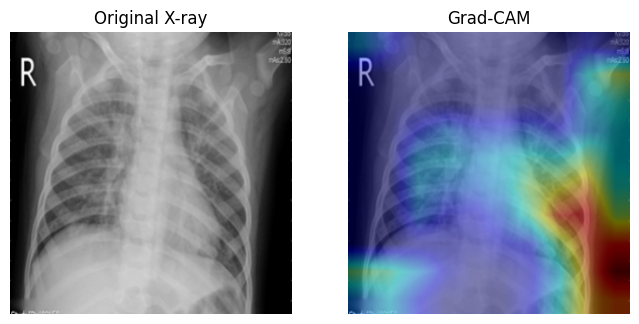

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# -----------------------------
# CONFIG
# -----------------------------
MODEL_PATH = "xray_classifier_b3_3class1.keras"
IMAGE_PATH = "Viral Pneumonia-1.png"
OUTPUT_DIR = "outputs"
IMG_SIZE = (300, 300)
LAST_CONV_LAYER = "top_conv"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# -----------------------------
# Load model
# -----------------------------
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("✅ Model loaded successfully")

# Force build
_ = model(tf.zeros((1, 300, 300, 3)))

# Split model
base_model = model.get_layer("efficientnetb3")
classifier = tf.keras.Sequential(model.layers[1:])

# -----------------------------
# Load image
# -----------------------------
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise FileNotFoundError("Image not found")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, IMG_SIZE)
img_norm = img / 255.0
input_tensor = np.expand_dims(img_norm, axis=0)

# -----------------------------
# Prediction
# -----------------------------
preds = model.predict(input_tensor)
pred_class = np.argmax(preds)
confidence = preds[0][pred_class]
print(f"Predicted class: {pred_class}, Confidence: {confidence:.2f}")

# -----------------------------
# Grad-CAM model (SAFE)
# -----------------------------
grad_model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=[
        base_model.get_layer(LAST_CONV_LAYER).output,
        base_model.output
    ]
)

# -----------------------------
# Compute Grad-CAM
# -----------------------------
with tf.GradientTape() as tape:
    conv_outputs, features = grad_model(input_tensor)
    predictions = classifier(features)
    loss = predictions[:, pred_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

heatmap = tf.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap)
heatmap = heatmap.numpy()

# -----------------------------
# Overlay
# -----------------------------
heatmap = cv2.resize(heatmap, IMG_SIZE)
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

overlay = cv2.addWeighted(
    cv2.cvtColor(img, cv2.COLOR_RGB2BGR),
    0.6,
    heatmap,
    0.4,
    0
)

output_path = os.path.join(OUTPUT_DIR, "gradcam_result.png")
cv2.imwrite(output_path, overlay)

print("✅ Grad-CAM saved to:", output_path)

# -----------------------------
# Display
# -----------------------------
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original X-ray")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()

In [11]:
!pip install fastapi uvicorn pyngrok


In [33]:
from fastapi import FastAPI, UploadFile, File
import tensorflow as tf
import numpy as np
import cv2

app = FastAPI()

IMG_SIZE = (300, 300)
CLASS_NAMES = ["COVID", "Normal", "Viral Pneumonia"]

print("🟡 Loading FULL saved model...")
model = tf.keras.models.load_model(
    "/content/xray_classifier_b3_3class1.keras",
    compile=False
)
print("✅ Model loaded correctly")


@app.get("/")
def health():
    return {"status": "Colab API running"}


@app.post("/predict")
def predict(image: UploadFile = File(...)):
    print("🟡 Predict request:", image.filename)

    # Read bytes
    contents = image.file.read()
    np_img = np.frombuffer(contents, np.uint8)

    img = cv2.imdecode(np_img, cv2.IMREAD_COLOR)
    if img is None:
        return {"error": "Invalid image"}

    # SAME preprocessing as training
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0

    input_tensor = np.expand_dims(img, axis=0)

    preds = model.predict(input_tensor)[0]
    idx = int(np.argmax(preds))

    return {
        "predictedClass": CLASS_NAMES[idx],
        "confidence": float(preds[idx]),
        "predictions": {
            CLASS_NAMES[i]: float(preds[i])
            for i in range(len(CLASS_NAMES))
        }
    }

🟡 Loading FULL saved model...
✅ Model loaded correctly


In [34]:
# 1️⃣ Install once
!pip install pyngrok nest_asyncio uvicorn

# 2️⃣ Imports
from pyngrok import ngrok
import nest_asyncio
import asyncio
from uvicorn import Config, Server

# 3️⃣ Apply notebook fix
nest_asyncio.apply()

# 4️⃣ Ngrok auth
ngrok.set_auth_token("37YoICs2NbWgEWGgJPycXTP2l7p_4ek5dfYPWnmdpdDd8URa9")

# 5️⃣ Start ngrok tunnel
public_url = ngrok.connect(8000)
print("🌍 Public URL:", public_url)

# 6️⃣ Start FastAPI server (CORRECT way)
config = Config(app=app, host="0.0.0.0", port=8000, log_level="info")
server = Server(config)

await server.serve()

🌍 Public URL: NgrokTunnel: "https://precedential-lavera-unconformable.ngrok-free.dev" -> "http://localhost:8000"


INFO:     Started server process [910]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     103.49.52.48:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     103.49.52.48:0 - "GET /openapi.json HTTP/1.1" 200 OK
🟡 Predict request: Viral Pneumonia-1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
INFO:     103.49.52.48:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     103.49.52.48:0 - "POST /predict HTTP/1.1" 422 Unprocessable Entity
INFO:     103.49.52.48:0 - "POST /predict HTTP/1.1" 422 Unprocessable Entity
INFO:     103.49.52.48:0 - "POST /predict HTTP/1.1" 422 Unprocessable Entity
🟡 Predict request: ba75f9c0fccd307bedf578d97d25d1e6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
INFO:     103.49.52.48:0 - "POST /predict HTTP/1.1" 200 OK
🟡 Predict request: 943bc1642a1c54aab80a3c448c3876a0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
INFO:     103.49.52.48:0 - "POST /predict HTTP/1.1" 200 OK
🟡 Predict request: 85ebef92306c643ba4e455521080f8ba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
INFO:     103.49.52.48:0 - "POST /predict HTTP/1.1" 200 OK
🟡 Predict request: 5fa628f12e71456eb57e7f3c7dd79141
1/1 ━━━━━━━━━━

INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [910]
